# Lithology classification

## Data

This notebook uses data from the [Upper Condamine Catchment](http://www.bom.gov.au/qld/flood/brochures/condamine_balonne/map_upper.shtml) in the state of Queensland. The data is sourced from personal communication as a project output. It may be shared publicly and downloadable from this sample notebook in the future.

![Upper Condamine catchment formations](img/Upper_Condamine_formations.png "Upper Condamine catchment formations")

(Figure from [this paper](https://www.researchgate.net/figure/Upper-Condamine-catchment-Queensland-Australia-The-Marburg-Subgroup-consists-of_fig1_283184727))

## Status

As of May 2019 this present document is an output from exploratory work done during an internship by [Sudhir Gupta](https://github.com/Sudhir22).


## Purpose

This notebook compares the performance of two techniques for semi-automated classification . It also summarise work using ontologies for classification for cases where we do not have reliable training sets.


## Importing python packages

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import geopandas as gpd
import pickle

In [2]:
# Only True for co-dev of ela from this use case:
ela_from_source = False
ela_from_source = True

In [3]:
if ela_from_source:
    if ('ELA_SRC' in os.environ):
        root_src_dir = os.environ['ELA_SRC']
    elif sys.platform == 'win32':
        root_src_dir = r'C:\Users\SUD011\Documents\pyela-sudhir'
    else:
        username = os.environ['USER']
        root_src_dir = os.path.join('/home', username, 'src/github_jm/pyela')
    pkg_src_dir = root_src_dir
    sys.path.insert(0, pkg_src_dir)

from ela.textproc import *
from ela.utils import *
from ela.classification import *
from ela.visual import *

In [4]:
import striplog
from striplog import Lexicon

In [5]:
if ('ELA_DATA' in os.environ):
    data_path = os.environ['ELA_DATA']
elif sys.platform == 'win32':
    data_path = r'C:\data\Lithology'
else:
    username = os.environ['USER']
    data_path = os.path.join('/home', username, 'data', 'Lithology')

condamine_litho_dir = os.path.join(data_path,'Condamine')
condamine_litho_xl = os.path.join(condamine_litho_dir, 'MASTER_CONDAMINE_Interpretation_all_combined_Jan2017.xlsx')
condamine_litho_pkl = os.path.join(condamine_litho_dir, 'MASTER_CONDAMINE_Interpretation_all_combined_Jan2017.pkl')

# Initial data exploration

This first section deliberately covers some of the data discovery process for didactic purposes.

## Useful resources

Note that some of the terms used for classification are triangulated with [this description](https://www.bioregionalassessments.gov.au/assessments/21-22-data-analysis-clarence-moreton-bioregion/21211-lithological-and-stratigraphic-data)

We cache the data in a pickle as it is faster to re-read:


In [6]:
if not os.path.exists(condamine_litho_pkl):
    train_data=pd.read_excel(condamine_litho_xl)
    with open(condamine_litho_pkl, 'wb') as handle:
        pickle.dump(train_data, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open(condamine_litho_pkl, 'rb') as handle:
        train_data = pickle.load(handle)

In [7]:
train_data.head()

,RN,Type,EASTING,NORTHING,Lithology_original,Simplified_lithology,Simplified_lithology_stratigraphy,From,To
0,202,new_bedrock_addition,385411.0,7014147.0,BROWN CLAY,BEDROCK,BEDROCK,0.00,10.67
1,202,new_bedrock_addition,385411.0,7014147.0,BROWN CLAY AND PIPE CLAY,BEDROCK,BEDROCK,10.67,24.38
2,202,new_bedrock_addition,385411.0,7014147.0,WHITE PIPE CLAY,BEDROCK,BEDROCK,24.38,26.82
3,202,new_bedrock_addition,385411.0,7014147.0,RED PIPE CLAY,BEDROCK,BEDROCK,26.82,31.70
4,202,new_bedrock_addition,385411.0,7014147.0,CLAY AND SAND,BEDROCK,BEDROCK,31.70,50.90


In [8]:
# train_data_unprocessed = train_data.copy()

In [9]:
df = train_data
LITHO_DESC_COL='Lithology_original'
REGEX_LITHO_CLASS_COL='Regex_lithoclass'

LITHO_CLASS_COL = 'Simplified_lithology'

In [10]:
set(train_data[LITHO_CLASS_COL].values)

{'ALLUVIUM',
 'Alluvium',
 'BASEMENT',
 'BEDROCK',
 'Basalt',
 'Basement',
 'Diorite',
 'GRAVEL',
 'Granite',
 'Granodiorite',
 'TERTIARY',
 'Unknown',
 'WEATHERING_HORIZON',
 'Wrong_location'}

We massage the column of simplified lithologies, resulting from a manual classification

In [11]:
# This is not obvious from inspection of the the pandas  data frame, but there appears to be NaNs that cause headaches later on.
vv = [x for x in df[LITHO_DESC_COL].values if not type(x) is str]

In [12]:
vv = [type(x) is not str for x in df[LITHO_DESC_COL].values]

In [13]:
df.loc[np.array(vv)].head()

,RN,Type,EASTING,NORTHING,Lithology_original,Simplified_lithology,Simplified_lithology_stratigraphy,From,To
12447,17920,Condamine_lockyer_add_April137,401022.0,6970291.0,NaN,BEDROCK,BEDROCK,89.31,91.44
72770,71240,Lockyer_upper,NaN,NaN,NaN,Basalt,Basalt,0.00,46.95
95698,87035,new_bedrock_addition,NaN,NaN,NaN,Unknown,Unknown,73.00,97.00


In [14]:
train_data[LITHO_CLASS_COL] = train_data[LITHO_CLASS_COL].replace(np.nan,'',regex=True)
train_data[LITHO_CLASS_COL] = train_data[LITHO_CLASS_COL].str.lower()
train_data[LITHO_DESC_COL] = train_data[LITHO_DESC_COL].replace(np.nan,'',regex=True)
train_data[LITHO_DESC_COL] = train_data[LITHO_DESC_COL].str.lower()

In [15]:
%%time

# Not obvious upfront but noticed that there are terms where dots and slashes prevent tokenization and lithology term detection. 
train_data[LITHO_DESC_COL] = v_replace_punctuations(train_data[LITHO_DESC_COL].values)

CPU times: user 447 ms, sys: 718 µs, total: 448 ms
Wall time: 446 ms


In [16]:
train_data.head()

,RN,Type,EASTING,NORTHING,Lithology_original,Simplified_lithology,Simplified_lithology_stratigraphy,From,To
0,202,new_bedrock_addition,385411.0,7014147.0,brown clay,bedrock,BEDROCK,0.00,10.67
1,202,new_bedrock_addition,385411.0,7014147.0,brown clay and pipe clay,bedrock,BEDROCK,10.67,24.38
2,202,new_bedrock_addition,385411.0,7014147.0,white pipe clay,bedrock,BEDROCK,24.38,26.82
3,202,new_bedrock_addition,385411.0,7014147.0,red pipe clay,bedrock,BEDROCK,26.82,31.70
4,202,new_bedrock_addition,385411.0,7014147.0,clay and sand,bedrock,BEDROCK,31.70,50.90


In [17]:
token_freq(train_data[LITHO_CLASS_COL].values, 50)

,token,frequency
0,basalt,71529
1,bedrock,52051
2,alluvium,49863
3,unknown,3761
4,granite,227
5,wrong_location,146
6,granodiorite,20
7,diorite,18
8,weathering_horizon,8
9,tertiary,4


Given the low frequency of some of the classes, we remap them to one of the three main classes:

In [18]:
train_data[LITHO_CLASS_COL] = train_data[LITHO_CLASS_COL].replace('granite|granodiorite|diorite|basement','bedrock',regex=True)
train_data[LITHO_CLASS_COL] = train_data[LITHO_CLASS_COL].replace('gravel','alluvium',regex=False)
train_data[LITHO_CLASS_COL] = train_data[LITHO_CLASS_COL].replace('wrong_location|weathering_horizon|tertiary','unknown',regex=True)

In [19]:
token_freq(train_data[LITHO_CLASS_COL].values, 50)

,token,frequency
0,basalt,71529
1,bedrock,52318
2,alluvium,49866
3,unknown,3919


In [20]:
descs = df[LITHO_DESC_COL]
descs = descs.reset_index()
descs = descs[LITHO_DESC_COL]
descs.head()

0                  brown clay
1    brown clay and pipe clay
2             white pipe clay
3               red pipe clay
4               clay and sand
Name: Lithology_original, dtype: object

In [21]:
lex = Lexicon.default()

In [22]:
%%time
expanded_descs = descs.apply(lex.expand_abbreviations)
y = expanded_descs.values

CPU times: user 2min 6s, sys: 63.3 ms, total: 2min 6s
Wall time: 2min 6s


In [23]:
train_data[LITHO_DESC_COL] = expanded_descs

We flatten the corpus of words to get the most frequend terms as a guide for which lithology classes we can define.

In [24]:
%%time
flat = flat_list_tokens(y)
len(set(flat))

CPU times: user 11.5 s, sys: 52 ms, total: 11.5 s
Wall time: 11.5 s


8683

In [25]:
df_most_common= token_freq(flat, 50)

In [26]:
df_most_common

,token,frequency
0,basalt,52596
1,clay,43979
2,brown,25723
3,sandstone,22196
4,grey,18225
5,sand,17938
6,shale,11616
7,soil,11286
8,wb,10925
9,honeycomb,10863


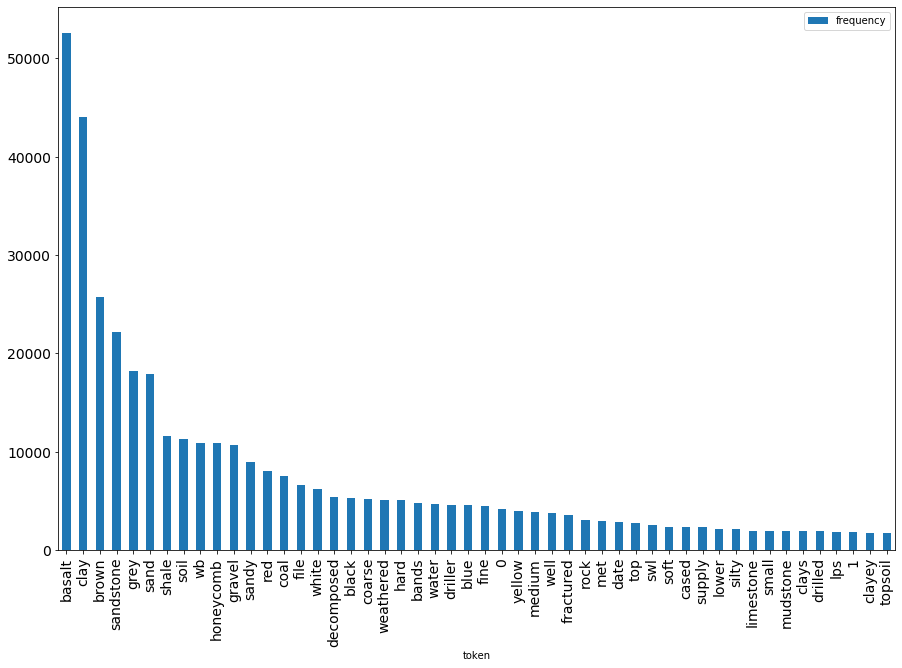

In [27]:
plot_freq(df_most_common)

In [28]:
condamine_litho_cleaned_pkl = os.path.join(condamine_litho_dir, 'condamine_litho_cleaned.pkl')

if not os.path.exists(condamine_litho_cleaned_pkl):
    with open(condamine_litho_cleaned_pkl, 'wb') as handle:
        pickle.dump(train_data, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open(condamine_litho_cleaned_pkl, 'rb') as handle:
        train_data = pickle.load(handle)
        y = train_data[LITHO_DESC_COL]
        
        

In [29]:
y = train_data[LITHO_DESC_COL]

# Defining lithology classes

Starting with the three terms we want to end up with, we can also add the most frequent terms observed in the corpus.


In [30]:
lithologies = ['alluvium', 'basalt', 'bedrock', 'clay', 'sandstone','sand','shale','soil','honeycomb','gravel','coal','gravel','silt','soil','rock', 'limestone', 'metal']
# see https://www.bioregionalassessments.gov.au/assessments/21-22-data-analysis-clarence-moreton-bioregion/21211-lithological-and-stratigraphic-data
# for 'metal' or 'blue metal'
any_litho_markers_re = r'alluvium|sand|clay|ston|shale|basa|silt|soil|honey|coal|gravel|rock|mud|metal'

regex = re.compile(any_litho_markers_re)

lithologies_dict = dict([(x,x) for x in lithologies])
lithologies_dict['sands'] = 'sand'
lithologies_dict['basalts'] = 'basalt'
lithologies_dict['clays'] = 'clay'
lithologies_dict['shales'] = 'shale'
lithologies_dict['claystone'] = 'clay'
lithologies_dict['siltstone'] = 'silt'
lithologies_dict['mudstone'] = 'silt' # ??
lithologies_dict['capstone'] = 'limestone' # ??
lithologies_dict['ironstone'] = 'sandstone' # ??
lithologies_dict['topsoil'] = 'soil' # ??

lithologies_adjective_dict = {
    'sandy' :  'sand',
    'clayey' :  'clay',
    'clayish' :  'clay',
    'shaley' :  'shale',
    'silty' :  'silt',
    'gravelly' :  'gravel'
}

In [31]:
%%time
v_tokens = v_word_tokenize(y)

CPU times: user 10.2 s, sys: 24 ms, total: 10.2 s
Wall time: 10.2 s


In [32]:
%%time
vt = v_find_litho_markers(v_tokens, regex=regex)

CPU times: user 352 ms, sys: 2 µs, total: 352 ms
Wall time: 351 ms


In [33]:
zero_mark = len([x for x in vt if len(x) == 0 ])
at_least_one_mark = len([x for x in vt if len(x) >= 1])
at_least_two_mark = len([x for x in vt if len(x) >= 2])
print('There are %s entries with no marker, %s entries with at least one, %s with at least two'%(zero_mark,at_least_one_mark,at_least_two_mark))

There are 4454 entries with no marker, 173178 entries with at least one, 44648 with at least two


# Testing the regular expression model on the Condamine dataset

We have one first pass at classifying into one of the three target classes.

In [34]:
prim_litho = [find_primary_lithology(x, lithologies_dict) for x in vt]

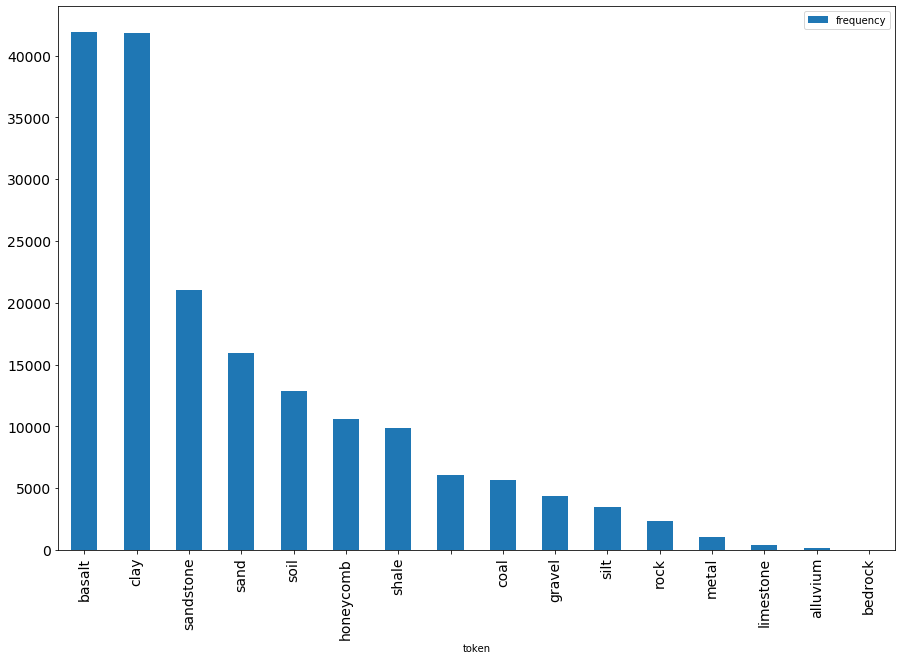

In [35]:
n = len(set(prim_litho))
plot_freq(token_freq(prim_litho, n_most_common = n))

We define a map of classes down to alluvium, bedrock, basalt or unknown.

We will do a bit of "snooping" on the labelled data; this is not ideal but is necessary to validate some classification assumptions.

Given the a priori classification of primary lithologies, what proportions of labels do we have for each primary lithologhy?



In [36]:
tmp_df = pd.DataFrame({ LITHO_CLASS_COL: train_data[LITHO_CLASS_COL], REGEX_LITHO_CLASS_COL: prim_litho, LITHO_DESC_COL: descs})

In [37]:
def class_freq_for_lithology(litho_name):
    blah = tmp_df.loc[tmp_df[REGEX_LITHO_CLASS_COL] == litho_name]
    return token_freq(blah[LITHO_CLASS_COL].values, 50)

In [38]:
class_freq_for_lithology('clay')

,token,frequency
0,alluvium,24163
1,bedrock,8597
2,basalt,7672
3,unknown,1396


In [39]:
class_freq_for_lithology('sand')

,token,frequency
0,alluvium,13921
1,bedrock,1492
2,unknown,422
3,basalt,112


In [40]:
class_freq_for_lithology('soil')

,token,frequency
0,alluvium,5601
1,basalt,5343
2,bedrock,1548
3,unknown,344


In [41]:
class_freq_for_lithology('honeycomb')

,token,frequency
0,basalt,10589
1,bedrock,12
2,alluvium,12
3,unknown,11


In [42]:
class_freq_for_lithology('shale')

,token,frequency
0,bedrock,9345
1,basalt,430
2,unknown,71
3,alluvium,10


In [43]:
class_freq_for_lithology('coal')

,token,frequency
0,bedrock,4968
1,basalt,628
2,alluvium,63
3,unknown,29


In [44]:
class_freq_for_lithology('gravel')

,token,frequency
0,alluvium,3193
1,basalt,599
2,bedrock,415
3,unknown,126


In [45]:
class_freq_for_lithology('silt')

,token,frequency
0,bedrock,2992
1,alluvium,370
2,basalt,97
3,unknown,25


We define a map from primary lithology terms to the simplified lithologies we have in the labelled data set. 
Note that to some extent there is some "snooping" on the labelled data, above, though we think justifiable in the context using regular expression.  

In [46]:
lithology_map={
    'alluvium' :  'alluvium',
    'bedrock' :  'bedrock',
    'basalt' :  'basalt',
    'metal' :  'basalt',
    'honeycomb' :  'basalt',
    'clay' :  'alluvium',
    'coal' :  'bedrock', 
    'sandstone' :  'bedrock',
    'sand' :  'alluvium',
    '' :  'unknown',
    'soil' :  'alluvium',
    'shale': 'bedrock',
    'gravel': 'alluvium',
    'silt' : 'bedrock',
    'rock' : 'bedrock',
    'limestone' : 'alluvium'
}

In [47]:
final_prim_litho=list()
for x in prim_litho:
    final_prim_litho.append(lithology_map[x])


In [48]:
token_freq(final_prim_litho)

,token,frequency
0,alluvium,75521
1,basalt,53592
2,bedrock,42425
3,unknown,6094


In [49]:
simplified_lithology=train_data[LITHO_CLASS_COL].values

In [50]:
def get_accuracy(modelled, expected):
    matches = np.equal(modelled, expected)
    return np.count_nonzero(matches)/len(matches)

In [51]:
print("Accuracy of regex for classifying primary lithologies: ", get_accuracy(final_prim_litho, simplified_lithology))

Accuracy of regex for classifying primary lithologies:  0.7876452441001621


Let's check what lithology descriptions led to an 'unknown' classification to see whether we are missing something

In [52]:
tmp_df = pd.DataFrame({ LITHO_CLASS_COL: train_data[LITHO_CLASS_COL], REGEX_LITHO_CLASS_COL: final_prim_litho, LITHO_DESC_COL: descs})

In [53]:
match_and_sample_df(tmp_df, 'unknown', colname=REGEX_LITHO_CLASS_COL, size=100)

,Simplified_lithology,Regex_lithoclass,Lithology_original
139413,bedrock,unknown,brown stone
77563,alluvium,unknown,sandy loam
156662,basalt,unknown,decomposed
36417,basalt,unknown,volcanic ash
16643,alluvium,unknown,dark brown loam
3397,alluvium,unknown,file t1267 drilled prior 1962
123438,unknown,unknown,light grey granite
97225,bedrock,unknown,grey sanbdstone
98391,basalt,unknown,green volc
125355,unknown,unknown,traprock


In [54]:
df_unk = tmp_df.loc[ tmp_df[REGEX_LITHO_CLASS_COL] == 'unknown' ]
df_unk.head()

,Simplified_lithology,Regex_lithoclass,Lithology_original
5,bedrock,unknown,quartzite small supply struck 197 ft
7,bedrock,unknown,quartzite stands test 247 ft 300 gph
8,bedrock,unknown,slate
10,bedrock,unknown,quartzite
12,bedrock,unknown,quartzite


In [55]:
flat = flat_list_tokens(df_unk[LITHO_DESC_COL].values)

In [56]:
s = ' '.join(flat)

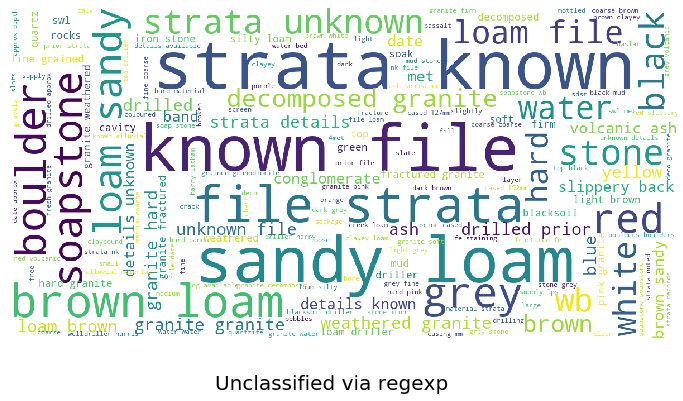

In [57]:
show_wordcloud(s, title = 'Unclassified via regexp')

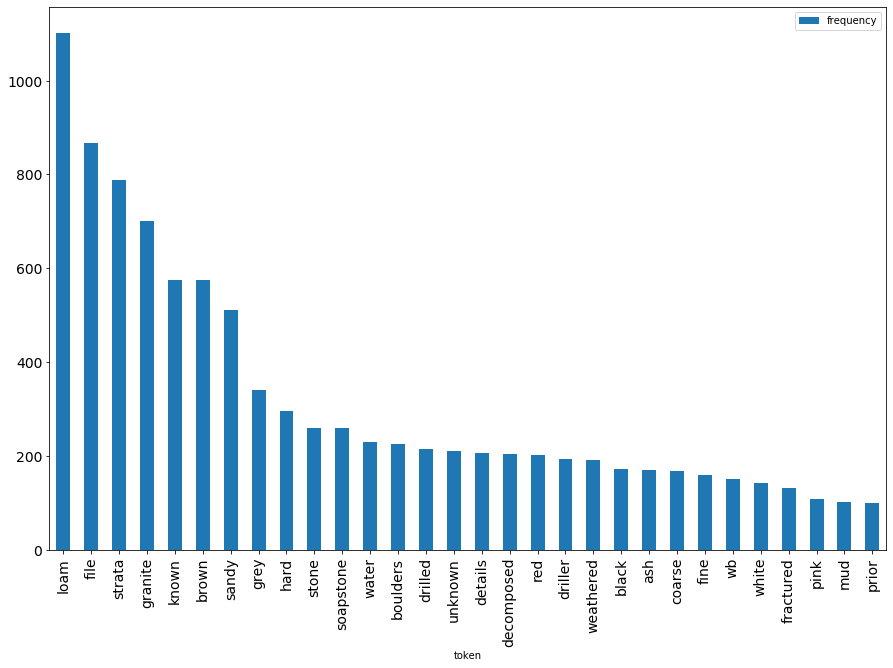

In [58]:
plot_freq(token_freq(flat, n_most_common = 30))

We did not use 'loam' as a term. There are others that should be used, but it is unclear how they should be remapped, like "metal" and "file"

In [59]:
lithologies.append('loam')
lithologies.append('granite')
lithologies.append('soapstone')

In [60]:
any_litho_markers_re = any_litho_markers_re + '|loam|granite|soap'
regex = re.compile(any_litho_markers_re)
lithologies_dict['loam'] = 'loam'
lithologies_dict['granite'] = 'granite'
lithologies_dict['soapstone'] = 'soapstone'

In [61]:
v_tokens = v_word_tokenize(y)
vt = v_find_litho_markers(v_tokens, regex=regex)

In [62]:
prim_litho = [find_primary_lithology(x, lithologies_dict) for x in vt]

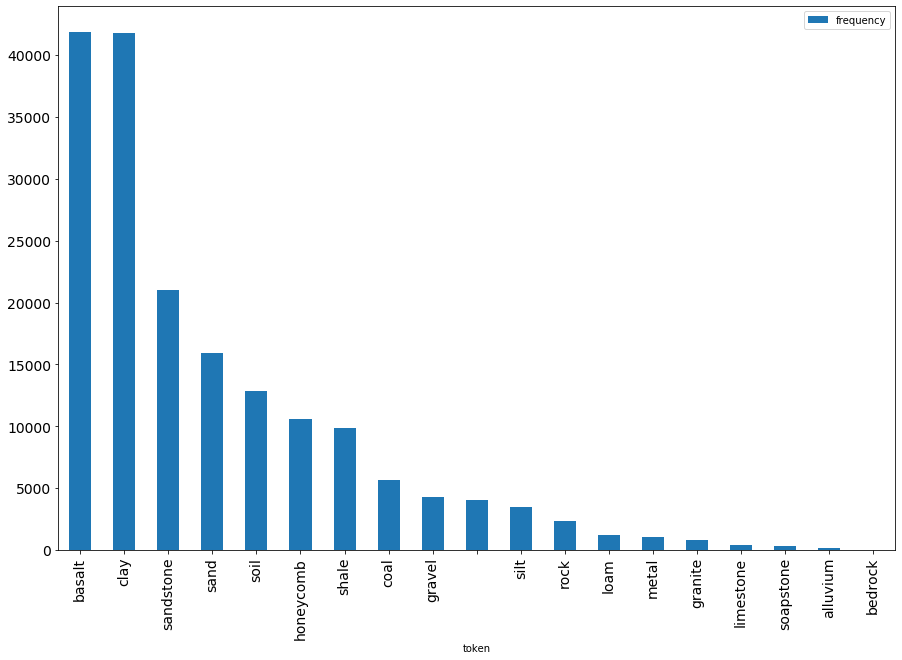

In [63]:
n = len(set(prim_litho))
plot_freq(token_freq(prim_litho, n_most_common = n))

In [64]:
lithology_map['loam'] = 'alluvium'
lithology_map['granite'] = 'bedrock'
lithology_map['soapstone'] = 'bedrock'

In [65]:
final_prim_litho=list()
for x in prim_litho:
    final_prim_litho.append(lithology_map[x])


In [66]:
token_freq(final_prim_litho)

,token,frequency
0,alluvium,76595
1,basalt,53521
2,bedrock,43485
3,unknown,4031


In [67]:
tmp_df = pd.DataFrame({ LITHO_CLASS_COL: train_data[LITHO_CLASS_COL], REGEX_LITHO_CLASS_COL: final_prim_litho, LITHO_DESC_COL: descs})

In [68]:
match_and_sample_df(tmp_df, 'unknown', colname=REGEX_LITHO_CLASS_COL, size=100)

,Simplified_lithology,Regex_lithoclass,Lithology_original
15239,unknown,unknown,strata not known file t 18744
4004,basalt,unknown,boulders driller agp
15966,unknown,unknown,file t4988 drilled approx 1940 depth
104803,bedrock,unknown,grey lam s stone med grain quartz w
118818,alluvium,unknown,very hard material
119207,bedrock,unknown,brown stone
144090,basalt,unknown,top brown driller harry latham
162236,alluvium,unknown,boulders hard
16204,basalt,unknown,strata not known file t 5070
52788,unknown,unknown,strata not known file t 5946


In [69]:
print("Accuracy of regex for classifying primary lithologies: ", get_accuracy(final_prim_litho, simplified_lithology))

Accuracy of regex for classifying primary lithologies:  0.7911018284993695


In [70]:
tmp_df = pd.DataFrame({ LITHO_CLASS_COL: train_data[LITHO_CLASS_COL], REGEX_LITHO_CLASS_COL: final_prim_litho, LITHO_DESC_COL: descs})

In [71]:
df_unk = tmp_df.loc[ tmp_df[REGEX_LITHO_CLASS_COL] == 'unknown' ]
df_unk.head()

,Simplified_lithology,Regex_lithoclass,Lithology_original
5,bedrock,unknown,quartzite small supply struck 197 ft
7,bedrock,unknown,quartzite stands test 247 ft 300 gph
8,bedrock,unknown,slate
10,bedrock,unknown,quartzite
12,bedrock,unknown,quartzite


In [72]:
flat = flat_list_tokens(df_unk[LITHO_DESC_COL].values)

In [73]:
s = ' '.join(flat)

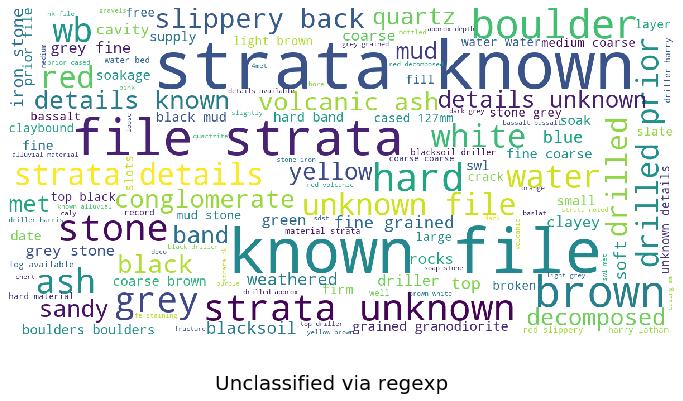

In [74]:
show_wordcloud(s, title = 'Unclassified via regexp')

In [75]:
def regex_matches(x, regex):
    return (regex.match(x) is not None)

def find_regex_df(df, expression, colname):
    """Sample a random subset of rows where the lithology column matches a particular class name.

        Args:
            df (pandas data frame): bore lithology data  with columns named PRIMARY_LITHO_COL
    
        Returns:
            dataframe:
    """
    tested = df[colname].values
    regex = re.compile(expression)
    xx = [(regex.match(x) is not None) for x in tested]
    df_test = df.loc[xx]
    return df_test

In [76]:
# find_regex_df( df_unk, '.*basalt.*', LITHO_DESC_COL)
# find_regex_df( df_unk, '.*file.*', LITHO_DESC_COL)

match_and_sample_df(tmp_df, 'unknown', colname=REGEX_LITHO_CLASS_COL, out_colname=None, size=50, seed=0)

,Simplified_lithology,Regex_lithoclass,Lithology_original
111628,bedrock,unknown,honey s stone fine quartz w
97640,basalt,unknown,weathered zone
43077,alluvium,unknown,boulders
145904,alluvium,unknown,
2330,alluvium,unknown,blue creek stones casing 152 mms 0
25731,alluvium,unknown,blacksoil driller sainsbury file 257
16243,unknown,unknown,file t497 drilled approx 1948
43769,alluvium,unknown,gravels
141397,bedrock,unknown,top black driller harry latham
91482,basalt,unknown,volcanic ash swl47 2 0 8l s


In [77]:
df_regex = df.copy()
df_regex[REGEX_LITHO_CLASS_COL] = final_prim_litho

In [78]:
condamine_litho_regex = os.path.join(condamine_litho_dir, 'condamine_litho_regex.pkl')
with open(condamine_litho_regex, 'wb') as handle:
    pickle.dump(df_regex, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Testing the deep learning model on the same dataset

In [79]:
# train_data=train_data_unprocessed.copy()

In [80]:
# conda install gensim
# conda install tensorflow
# conda install keras
# pip install wordcloud

from ela.experiment.textproc import Model

Using TensorFlow backend.


In [81]:
train_data_dl = train_data.copy()
model=Model(train_data_dl,20)

NOTE 2019-07-30: reloading cached results as the training takes a fair amount of time.

In [82]:
predictions_dl = pd.read_csv('prediction_file.csv')

In [ ]:
# model.initialise_model()

As of 2019-07-20: 

* Training Accuracy: 0.8620
* Testing Accuracy:  0.8562


In [ ]:
#x = train_data.copy()
#x.head()

In [ ]:
#x['Description'] = x['Lithology_original']
#model.predict(x)

In [83]:
predictions_dl.head()

,RN,Type,EASTING,NORTHING,Lithology_original,Simplified_lithology,Simplified_lithology_stratigraphy,From,To,Description,Simplified_Lithology
0,202,new_bedrock_addition,385411.0,7014147.0,brown clay,bedrock,BEDROCK,0.00,10.67,brown clay,alluvium
1,202,new_bedrock_addition,385411.0,7014147.0,brown clay and pipe clay,bedrock,BEDROCK,10.67,24.38,brown clay and pipe clay,alluvium
2,202,new_bedrock_addition,385411.0,7014147.0,white pipe clay,bedrock,BEDROCK,24.38,26.82,white pipe clay,bedrock
3,202,new_bedrock_addition,385411.0,7014147.0,red pipe clay,bedrock,BEDROCK,26.82,31.70,red pipe clay,basalt
4,202,new_bedrock_addition,385411.0,7014147.0,clay and sand,bedrock,BEDROCK,31.70,50.90,clay and sand,alluvium


In [84]:
print("Accuracy of DL for classifying primary lithologies: ", get_accuracy(predictions_dl['Simplified_Lithology'], simplified_lithology))

Accuracy of DL for classifying primary lithologies:  0.8602278868672312


## Explaining the predictive performance of regexp versus DL

* Confusion matrices for RE and DL
* Subset each case where DL gets is right and not RE, and get a wordcloud of terms
* Subset each case where RE gets is right and not DL, and get a wordcloud of terms

In [85]:
##

condamine_litho_regex = os.path.join(condamine_litho_dir, 'condamine_litho_regex.pkl')
with open(condamine_litho_regex, 'rb') as handle:
    df_regex = pickle.load(handle)

In [86]:
from sklearn.metrics import confusion_matrix

df_regex.head()

,RN,Type,EASTING,NORTHING,Lithology_original,Simplified_lithology,Simplified_lithology_stratigraphy,From,To,Regex_lithoclass
0,202,new_bedrock_addition,385411.0,7014147.0,brown clay,bedrock,BEDROCK,0.00,10.67,alluvium
1,202,new_bedrock_addition,385411.0,7014147.0,brown clay and pipe clay,bedrock,BEDROCK,10.67,24.38,alluvium
2,202,new_bedrock_addition,385411.0,7014147.0,white pipe clay,bedrock,BEDROCK,24.38,26.82,alluvium
3,202,new_bedrock_addition,385411.0,7014147.0,red pipe clay,bedrock,BEDROCK,26.82,31.70,alluvium
4,202,new_bedrock_addition,385411.0,7014147.0,clay and sand,bedrock,BEDROCK,31.70,50.90,alluvium


In [87]:
litho_class_names = ["basalt", "bedrock", "alluvium", "unknown"]

In [88]:
def build_confusion_matrix(df_regex, colname_true, colname_predicted, labels = litho_class_names):
    y_true = df_regex[colname_true].values
    y_pred = df_regex[colname_predicted].values    
    m = confusion_matrix(y_true, y_pred, labels=labels)
    return m

def normalise_confusion_matrix(m):
    fractions = m / m.astype(np.float).sum(axis=0)
    return fractions

def plot_cf_matrix(m, litho_class_names, title='confusion matrix', figsize = (10,7), cmap='coolwarm', center=None):
    """
    """
    df_cm = pd.DataFrame(m, index = [i for i in litho_class_names],
                      columns = [i for i in litho_class_names])
    plt.figure(figsize = figsize)
    sn.heatmap(df_cm, annot=True, cmap=cmap, center=center)
    plt.title(title)
    plt.xlabel('predicted')
    plt.ylabel('actual')
    plt.show()
    

In [89]:
sn.set(font_scale=1.4)

In [90]:
m_regex = build_confusion_matrix(df_regex, colname_true=LITHO_CLASS_COL, colname_predicted=REGEX_LITHO_CLASS_COL)
fractions_regex = normalise_confusion_matrix(m_regex)

m_dl = build_confusion_matrix(predictions_dl, colname_true='Simplified_lithology', colname_predicted='Simplified_Lithology')
fractions_dl = normalise_confusion_matrix(m_dl)

In [91]:
diff_frac = fractions_dl - fractions_regex

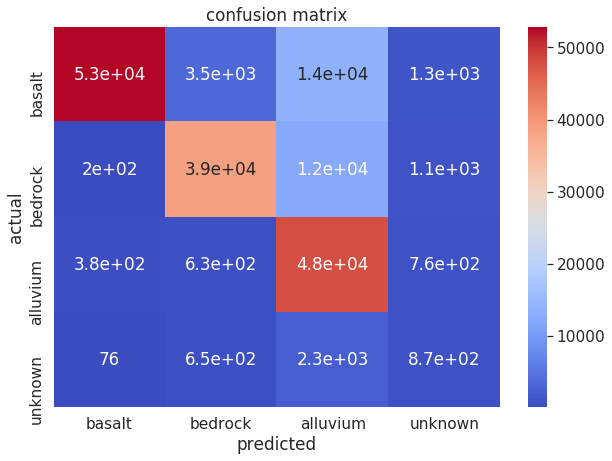

In [92]:
plot_cf_matrix(m_regex, litho_class_names, title='confusion matrix')

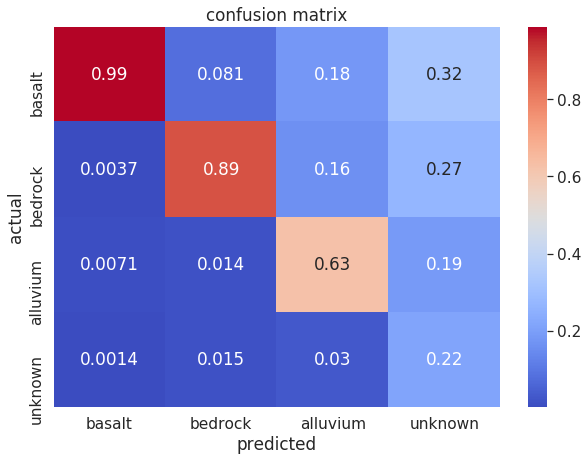

In [93]:
plot_cf_matrix(fractions_regex, litho_class_names)

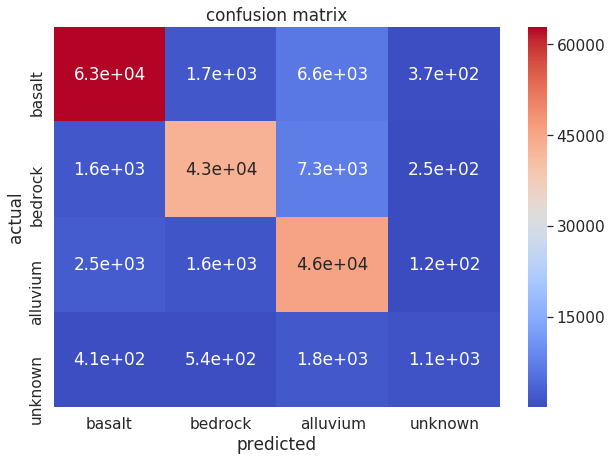

In [94]:
plot_cf_matrix(m_dl, litho_class_names)

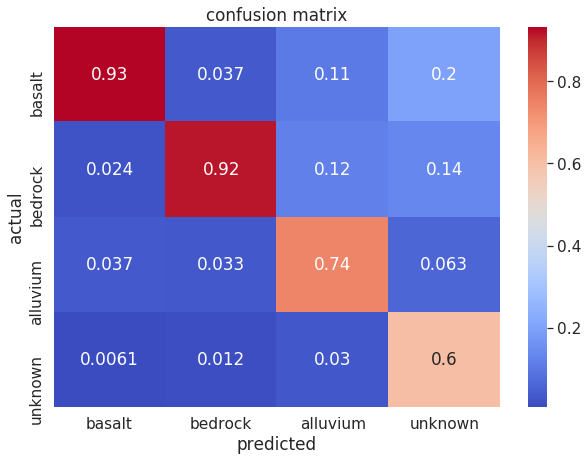

In [95]:
plot_cf_matrix(fractions_dl, litho_class_names)

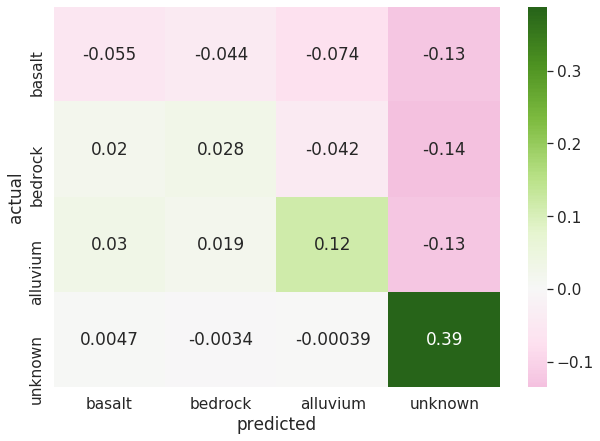

In [96]:
plot_cf_matrix(diff_frac, litho_class_names, title='', cmap="PiYG", center=0)

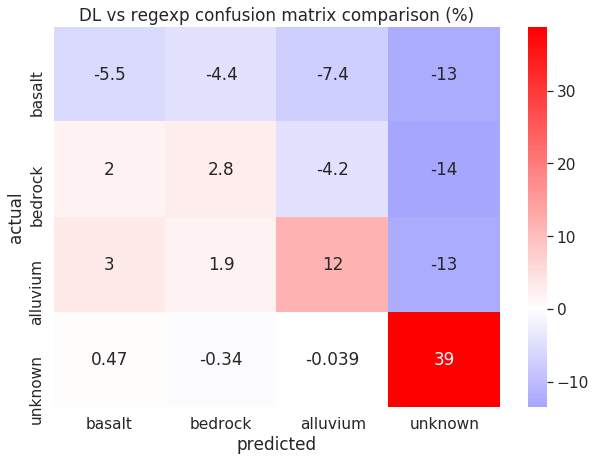

In [97]:
plot_cf_matrix(diff_frac * 100, litho_class_names, title='DL vs regexp confusion matrix comparison (%)', cmap='bwr', center=0)

In [98]:
# double-checking the normalisation procedure
#true_counts = m.astype(np.float).sum(axis=1) # true preds
#f = m / true_counts
#f
#f = m / m.astype(np.float).sum(axis=0)
#f
#f.sum(axis=0), f.sum(axis=1)

len(df_regex)

177632

# Checking the accuracy if geolocation and log descriptions are taken as input features 

Logistic Regression for classifying lithologies based on geolocation. Combining the outputs of the logistic regression model and the deep learning model.

In [ ]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [ ]:
train_data = train_data_unprocessed.copy()
set(train_data['Simplified_lithology'].values)

In [ ]:
train_data['Simplified_lithology']=train_data['Simplified_lithology'].replace(np.nan,'Unknown',regex=True)

In [ ]:
train_data['Simplified_lithology']=train_data['Simplified_lithology'].str.lower()

In [ ]:
set(train_data['Simplified_lithology'].values)

In [ ]:
train_data['Simplified_lithology'],labels=pd.factorize(train_data['Simplified_lithology'])

In [ ]:
train_X=train_data[['EASTING','NORTHING']][0:len(model.train_X)]
test_X=train_data[['EASTING','NORTHING']][len(model.train_X):]
train_y=train_data['Simplified_lithology'][0:len(model.train_X)]
test_y=train_data['Simplified_lithology'][len(model.train_X):]
train_X.replace(np.nan,0.0,inplace=True)
test_X.replace(np.nan,0.0,inplace=True)
print(train_X.shape)
print(train_y.shape)


In [ ]:
clf=LogisticRegression(C=0.01)

In [ ]:
clf.fit(train_X,train_y)

In [ ]:
y_pred=clf.predict_proba(test_X)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
train_data=train_data_unprocessed.copy()
new_df=pd.DataFrame(train_data[['Lithology_original']].values,columns=['Description'])

In [ ]:
new_df.head()

In [ ]:
new_df = new_df[len(model.train_X):].copy()

In [ ]:
y_pred_dl=model.predict_certainity(new_df)

In [ ]:
y_pred, y_pred_dl

In [ ]:
print(y_pred.shape)
print(y_pred_dl.shape)

In [ ]:
final_class_prob=np.mean(np.array([y_pred,y_pred_dl]), axis=0 )

In [ ]:
print(final_class_prob.shape)

In [ ]:
final_output_numerical=np.argmax(final_class_prob,axis=1)

In [ ]:
print(accuracy_score(test_y,final_output_numerical))

In [ ]:
simplified_lithology_categories=[]
for x in final_output_numerical:
    simplified_lithology_categories.append(labels[x])

It does not increase the accuracy. Don't think the geolocation has an impact on the simplified lithologies

# Ontology based learning

Python provides libraries such as RDFLib, OWL 2 for working with ontologies. OWL 2 is better suited for ontology oriented programming since it offers a more pythonic way of managing/creating ontologies.
But then, RDFLib works well with .rdf files. Hence, there is a trade-off. Can use based on individual project needs. <br>

Protege is an 'IDE' which can be used to manage/create ontologies. It was developed at Stanford and can be downloaded from here [Protege](https://protege.stanford.edu/)<br>
Protege can be used to visualise the different relationships defined in an ontology <br>

The ontology that I am using can be downloaded from [here](http://ontologydesignpatterns.org/wiki/Ontology:CGI_Simple_Lithology_201001)

In [ ]:
import rdflib as rd

In [ ]:
from rdflib.namespace import SKOS
from rdflib.namespace import RDFS

In [ ]:
ontology=rd.Graph()
condamine_litho_ontology = os.path.join(condamine_litho_dir, 'SimpleLithology201001.rdf')
ontology.parse(condamine_litho_ontology)

In [ ]:
lithology_dictionary=dict()
for x,y in ontology.subject_objects(SKOS.prefLabel):
    lithology_dictionary[x]=y
    

In [ ]:
for x,y in ontology.subject_objects(SKOS.broader):
    if x in lithology_dictionary.keys() and y in lithology_dictionary.keys():
        print(" broader class of ",lithology_dictionary[x]," is ",lithology_dictionary[y])

<h5>These relationships can be converted into fuzzy if-then rules and fed to the machine learning model to make better decisions. <br>
Above is only one kind of relationship. We have other relationships such as narrower, description of each label etc. All these combined would make a very "knowledgeable" machine learning model. </h5>

### Comparing visually

Optional



## Observations and discussions

DL much better than regular expressions.<br>

Regular expressions use a set of keywords and look for matches in the descriptions. Sometimes, these keywords might not be in the descriptions.<br>

Similarly, regular expressions map descriptions to a set of predefined catgories (clay,sand,etc.) which are further refined into broader categories ( alluvium,basalt,bedrock). Geoscientists confirm that the mapping is not one/many-to-one. For example,Clay could be part of alluvium/basalt. This cannot be achieved using the regular expression model.

DL, on the other hand, learns the descriptions of different lithology classes. Based on labelled data from geoscientists, DL model learns the different kinds of descriptions which would pertain to for e.g alluvium. 




## Conclusion and future work